# Winners

In [42]:
#import all libraries we used
import pandas as pd
from bs4 import BeautifulSoup
import requests
import html5lib
import os
import re
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')

## Crawling

In [2]:
#create our DataFrame

def createDf():
    data = {'Round': [], 'Season': [], 'Date':[], 'Hour':[], 'HomeTeam': [], 'GuestTeam': []
            , 'Score': [],'ScoreDiff':[],'Winners': []}
    df = pd.DataFrame(data)
    return df

In [3]:
#Create a string of two seasons

def season(firstY,secondY):
    years = firstY+"-"+secondY
    return years

In [4]:
#Create BeautifulSoup object

def load_soup_object(years,rounds):
    try:
        if years == "2016-2017":
            url = "https://www.worldfootball.net/schedule/esp-primera-division-"+years+"-spieltag_2/"+rounds
        else:
            url = "https://www.worldfootball.net/schedule/esp-primera-division-"+years+"-spieltag/"+rounds
        r = requests.get(url)
        soup = BeautifulSoup(r.text,'html.parser')
    except:
        print("there was problem in years "+ years + "and round "+rounds+".")
    return soup

In [5]:
#Insert our BeautifulSoup object to our Dataframe

def insertSoupToDataFrame(soup,df,rounds,years):
    
    date=list()
    hour=list()
    homeTeam=list()
    guestTeam=list()
    score=list()
    
    table = soup.find('table',attrs={"class":"standard_tabelle"})
    
    for row in table("tr"):
        cells = row("td")
        if(len(cells)<6):
            continue
        if cells[0].get_text() != "":
            temp = cells[0].get_text()
            date.append(cells[0].get_text())
        else:
            date.append(temp)
        hour.append(cells[1].get_text())
        homeTeam.append(cells[2].get_text().strip())
        guestTeam.append(cells[4].get_text().strip())
        score.append(cells[5].get_text().strip())
               
    data = {'Round': rounds, 'Season': years, 'Date':date, 'Hour':hour, 'HomeTeam': homeTeam, 'GuestTeam': guestTeam,
            'Score': score}
    df = pd.DataFrame(data)
    return df
    

In [6]:
#Our main function to get our data using the last functions of creatring BeautifulSoup and dataframe

def getData():
    yearList = ["2000", "2001", "2002","2003", "2004", "2005","2006", "2007", "2008","2009",
                "2010", "2011","2012", "2013", "2014","2015", "2016", "2017","2018", "2019", "2020","2021", "2022"]

    roundsList = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10",
                  "11", "12","13", "14", "15", "16", "17", "18", "19", "20",
                  "21", "22", "23", "24", "25", "26", "27", "28", "29", "30",
                  "31", "32", "33", "34", "35", "36", "37", "38"]

    df = createDf()
    tempYear = 0;
    tempRounds = 0;
    for year in yearList:
        if yearList[tempYear] == "2022" :
            break
        years = season(yearList[tempYear],yearList[tempYear+1])
        for rounds in roundsList:
            soup = load_soup_object(years,rounds)
            df1 = insertSoupToDataFrame(soup,df,rounds,years)
            df = df.append(df1, ignore_index=True)
            tempRounds = tempRounds+1
        tempYear=tempYear+1
    
    return df

## Cleaning the Data

In [7]:
#Check the score and fill winners column 

def getWinners(df):
    df1 = df.copy()
    temp = df.Score
    winners = list()
    for i in temp:
        if i[0] < i[2]:
            winners.append("Away")
        elif i[0] > i[2]:
            winners.append("Home")
        else:
            winners.append("Draw")
    df1.Winners = winners
    return df1

In [8]:
#Edit the score 

def editScore(df):
    df1 = df.copy()
    scoreList = df.Score
    tempDiff = 0
    diff = list()
    scoreEdit = list()
    for i in scoreList:
            i = i[0: 3]
            scoreEdit.append(i)
            try:
                temp = int(i[0]) - int(i[2])
            except:
                temp = "NaN"
            diff.append(temp)
    df1.Score = scoreEdit
    df1.ScoreDiff = diff
    return df1

In [9]:
def teamsToNumeric(df,first,second):
    df1 = df.copy()
    df1.loc[(df['HomeTeam'] == first),'HomeTeam']= 1
    df1.loc[(df['GuestTeam'] == second),'GuestTeam']= 2
    return df1

In [10]:
def winnersToNumeric(df):
    df1 = df.copy()
    df1.loc[(df.Winners == 'Home'),'Winners']= 1
    df1.loc[(df.Winners == 'Draw'),'Winners']= 0
    df1.loc[(df.Winners == 'Away'),'Winners']= 2

    return df1

In [37]:
def cleanDataAndMakeEda(df,firstTeam,secondTeam):
    df1 = df.copy()
    df2 = getWinners(df1)
    df3 = editScore(df2)
    df4 = df3.drop(['Season', 'Date','Hour'], axis=1)
    df5 = df4.dropna(axis=0)
    printEDA(df5,firstTeam,secondTeam)
    df6 = TwoTeamsDataFarmeFilterByOrder(df5,firstTeam,secondTeam)
    df7 = teamsToNumeric(df6,firstTeam,secondTeam)
    df8 = winnersToNumeric(df7)
    df9 = df8.drop(['Score'], axis=1)
    df10 = df9.astype('int')
    df11 = df10.copy()
    return df11

## EDA

In [12]:

# Filter DataFrame to have only games participated by a certine team (home & away)

def OneTeamDataFrameFilter(df, team):
    df1 = df.copy()
    return df1.loc[(df1['HomeTeam'] == team) | (df1['GuestTeam'] == team)]

In [13]:

#Filter DataFrame to have only games participated by certine 2 teams (home & away)

def TwoTeamsDataFarmeFilter(df, team1, team2):
    df1 = df.copy()
    return pd.concat([df1.loc[(df1['HomeTeam'] == team1) & (df1['GuestTeam'] == team2)],df1.loc[(df1['HomeTeam'] == team2) & (df1['GuestTeam'] == team1)]])

In [14]:

#Filter DataFrame to have only games participated by certine 2 teams (home & away) but this time by order

def TwoTeamsDataFarmeFilterByOrder(df, team1, team2):
    df1 = df.copy()
    return pd.concat([df1.loc[(df1['HomeTeam'] == team1) & (df1['GuestTeam'] == team2)]])

In [15]:

# charts maker

def one_dim_plot(sr, plot_type,plot_title,axis):
    return sr.plot(y=' ',kind=plot_type, title=plot_title,ax=axis)

In [16]:

# two teams win & loss ratio - pie chart

def TwoTeamsWinsPieChart(df, team1, team2,axis):
    df_copy = TwoTeamsDataFarmeFilter(df, team1, team2)
    
    team1_wins = len(df_copy[(df_copy['HomeTeam'] == team1) & (df_copy['Winners']=='Home')].index) + len(df_copy[(df_copy['GuestTeam'] == team1) & (df_copy['Winners']=='Away')].index)
    draws= 0
    for winner in df_copy.Winners:
        if winner == 'Draw':
            draws = draws+1
    team2_wins= len(df_copy[(df_copy['HomeTeam'] == team2) & (df_copy['Winners']=='Home')].index) + len(df_copy[(df_copy['GuestTeam'] == team2) & (df_copy['Winners']=='Away')].index)
    
    sr_data = pd.Series([team1_wins,draws,team2_wins], index=[team1, 'Draw', team2])
    one_dim_plot(sr_data, 'pie', f"{team1} & {team2} Matches",axis)

In [17]:

# one team win & loss all time ratio - pie chart

def OneTeamWinsPieChart(df, team,axis):
    df_copy =OneTeamDataFrameFilter(df, team)
    wins=len(df_copy[(df_copy['HomeTeam'] == team) & (df_copy['Winners']=='Home')].index) + len(df_copy[(df_copy['GuestTeam'] == team) & (df_copy['Winners']=='Away')].index)
    draws=0
    for winner in df_copy.Winners:
        if winner == 'Draw':
            draws = draws+1
    losses= len(df_copy.index)-wins-draws
    
    sr_data = pd.Series([wins,draws,losses], index=['Wins', 'Draws', 'Losses'])
    one_dim_plot(sr_data, 'pie', f"{team} Wins & Losses",axis)

In [18]:
# two teams goals all time ratio - pie chart

def TwoTeamsGoalsPieChart(df, team1, team2,axis):
    df_copy = TwoTeamsDataFarmeFilter(df, team1, team2)
    team1_score = 0
    team2_score = 0
    for index in df_copy.index:
        
        home_score = int(df_copy['Score'][index][0]) 
        away_score = int(df_copy['Score'][index][2] )
        
        if(df_copy['HomeTeam'][index] == team1):
            team1_score += home_score
            team2_score += away_score
        else:
            team1_score += away_score
            team2_score += home_score
            
    sr_data = pd.Series([team1_score,team2_score], index=[team1, team2])
    one_dim_plot(sr_data, 'pie', f"{team1} & {team2} Matches Total Goals",axis)

In [19]:

# one team goals all time ratio - pie chart

def OneTeamGoalsPieChart(df, team,axis):
    df_copy = OneTeamDataFrameFilter(df, team)
    scored = 0
    scored_to = 0
    for index in df_copy.index:
        try:
            home_score = int(df_copy['Score'][index][0]) 
            away_score = int(df_copy['Score'][index][2] )
        
            if(df_copy['HomeTeam'][index] == team):
                scored += home_score
                scored_to += away_score
            else:
                scored += away_score
                scored_to += home_score
        except:
            continue
    sr_data = pd.Series([scored,scored_to], index=['Scored', 'Scored To'])
    one_dim_plot(sr_data, 'pie', f"{team} Matches Total Goals",axis)

In [20]:

#

def HomeAwayWinLossRatiosBarChart(df, team,axis):
    df_copy = OneTeamDataFrameFilter(df,team)
    
    home_resault_df = pd.DataFrame({'Wins':[0,0], 'Losses':[0,0]}, index = ['Home','Away'])
    away_resault_df = pd.DataFrame({'Wins':[0], 'Losses':[0]}, index = ['Away'])
    
    for index in df_copy.index:
        if(df_copy['HomeTeam'][index] == team):
            if(df_copy['Winners'][index] == 'Home'):
                home_resault_df['Wins'][0]+=1
            else:
                home_resault_df['Losses'][0]+=1
        else:
            if(df_copy['Winners'][index] == 'Home'):
                home_resault_df['Losses'][1]+=1
            else:
                home_resault_df['Wins'][1]+=1
                
    ax = home_resault_df.plot.bar(rot=0,title=f"{team} Win & Loss for Home & Away " , ax=axis)  
    #print(home_resault_df)
        
    
    

In [21]:
def printEDA(df,firstTeam,secondTeam):
    fig, axes = plt.subplots(3,3, figsize=(20,20))
    HomeAwayWinLossRatiosBarChart(df, firstTeam,axes[0][0])
    HomeAwayWinLossRatiosBarChart(df, secondTeam,axes[0][1])
    OneTeamGoalsPieChart(df, firstTeam,axes[0][2])
    OneTeamGoalsPieChart(df, secondTeam,axes[1][0])
    TwoTeamsGoalsPieChart(df,firstTeam, secondTeam,axes[1][1])
    OneTeamWinsPieChart(df, firstTeam,axes[1][2])
    OneTeamWinsPieChart(df, secondTeam,axes[2][0])
    TwoTeamsWinsPieChart(df, firstTeam, secondTeam, axes[2][1])

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(20,5))
HomeAwayWinLossRatiosBarChart(df, 'Málaga CF',axes)

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(20,5))
HomeAwayWinLossRatiosBarChart(df, 'Atlético Madrid',axes)

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(20,5))
OneTeamGoalsPieChart(df,'Atlético Madrid',axes)

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(20,5))
TwoTeamsGoalsPieChart(df,'Atlético Madrid', 'Real Madrid',axes)

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(20,5))
OneTeamWinsPieChart(df, 'FC Barcelona', axes)

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(20,5))
TwoTeamsWinsPieChart(df, 'Real Zaragoza', 'FC Barcelona',axes)

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(20,5))
TwoTeamsWinsPieChart(df, 'Atlético Madrid', 'Real Madrid', axes)

## Machine Learning

In [22]:
def load_dataset(df, target_column):
    X = df
    y = X.pop(target_column)
    return X, y

### LinearRegression

In [23]:
def train_1st_model(X_train, y_train):
    trained_model=LinearRegression()
    trained_model.fit(X_train,y_train)
    
    return trained_model

In [24]:
def predict_1st(trained_1st_model, X_test):
    predict=trained_1st_model.predict(X_test)
    return predict

In [25]:
def linearRegerssion(df):
    train, test = train_test_split(df, test_size=0.2)
    
    X_1st_train, y_1st_train = load_dataset(train, "Winners")
    X_1st_test, y_1st_test = load_dataset(test, "Winners")
    trained_model_1st = train_1st_model(X_1st_train, y_1st_train)
    pred_1st_vals = predict_1st(trained_model_1st, X_1st_test)
 
    return pred_1st

### LogisticRegression

In [26]:
def train_2nd_model(X_train, y_train):
    trained_model = LogisticRegression()
    trained_model.fit(X_train, y_train)
    
    return trained_model

In [27]:
def predict_2nd(trained_2nd_model, X_test):
    predicted_vals=trained_2nd_model.predict(X_test)
    return predicted_vals

In [28]:
def evaluate_performance_2nd(y_test,y_predicted):
    evaluate_value= f1_score(y_test,y_predicted,average='micro')
    return evaluate_value

In [29]:
def logisticRegerssion(df):
    train, test = train_test_split(df, test_size=0.2)
    X_2nd_train, y_2nd_train = load_dataset(train, "Winners")
    X_2nd_test, y_2nd_test = load_dataset(test, "Winners")
    trained_model_2nd = train_2nd_model(X_2nd_train, y_2nd_train)
    pred_2nd_vals = predict_2nd(trained_model_2nd, X_2nd_test)
    y_pred_2nd = pd.Series(pred_2nd_vals,index=X_2nd_test.index)
    resDF=pd.DataFrame({"Actual":y_2nd_test,"Predicted":y_pred_2nd})
    eval_res_2nd = evaluate_performance_2nd(y_2nd_test, y_pred_2nd)
    evelSeries.append(eval_res_2nd)
    return y_pred_2nd,resDF,evelSeries

In [30]:
evelSeries=list()

## Main

### Get new data and save to csv

In [ ]:
df1 = getData()
df1.to_csv('data.csv')

### Using existing data from csv 

In [36]:
df = pd.read_csv('data.csv')
df1 = df.drop(['Unnamed: 0'], axis=1)
df1

,Round,Season,Date,Hour,HomeTeam,GuestTeam,Score,ScoreDiff,Winners
0,1,2000-2001,09/09/2000,NaN,Real Zaragoza,Espanyol Barcelona,1:2 (0:0),NaN,NaN
1,1,2000-2001,09/09/2000,NaN,Real Madrid,Valencia CF,2:1 (0:0),NaN,NaN
2,1,2000-2001,09/09/2000,NaN,FC Barcelona,Málaga CF,2:1 (2:0),NaN,NaN
3,1,2000-2001,09/09/2000,NaN,Deportivo La Coruña,Athletic Bilbao,2:0 (0:0),NaN,NaN
4,1,2000-2001,09/09/2000,NaN,Real Sociedad,Racing Santander,2:2 (0:0),NaN,NaN
...,...,...,...,...,...,...,...,...,...
8355,38,2021-2022,22/05/2022,19:00,CD Alavés,Cádiz CF,0:1 (0:0),NaN,NaN
8356,38,2021-2022,22/05/2022,19:00,Granada CF,Espanyol Barcelona,0:0 (0:0),NaN,NaN
8357,38,2021-2022,22/05/2022,21:00,FC Barcelona,Villarreal CF,0:2 (0:1),NaN,NaN
8358,38,2021-2022,22/05/2022,21:00,Sevilla FC,Athletic Bilbao,1:0 (0:0),NaN,NaN


[0.6, 0.8000000000000002, 1.0, 0.8000000000000002]


,Actual,Predicted
5402,1,1
3724,2,2
240,0,1
5228,2,2
2349,1,1


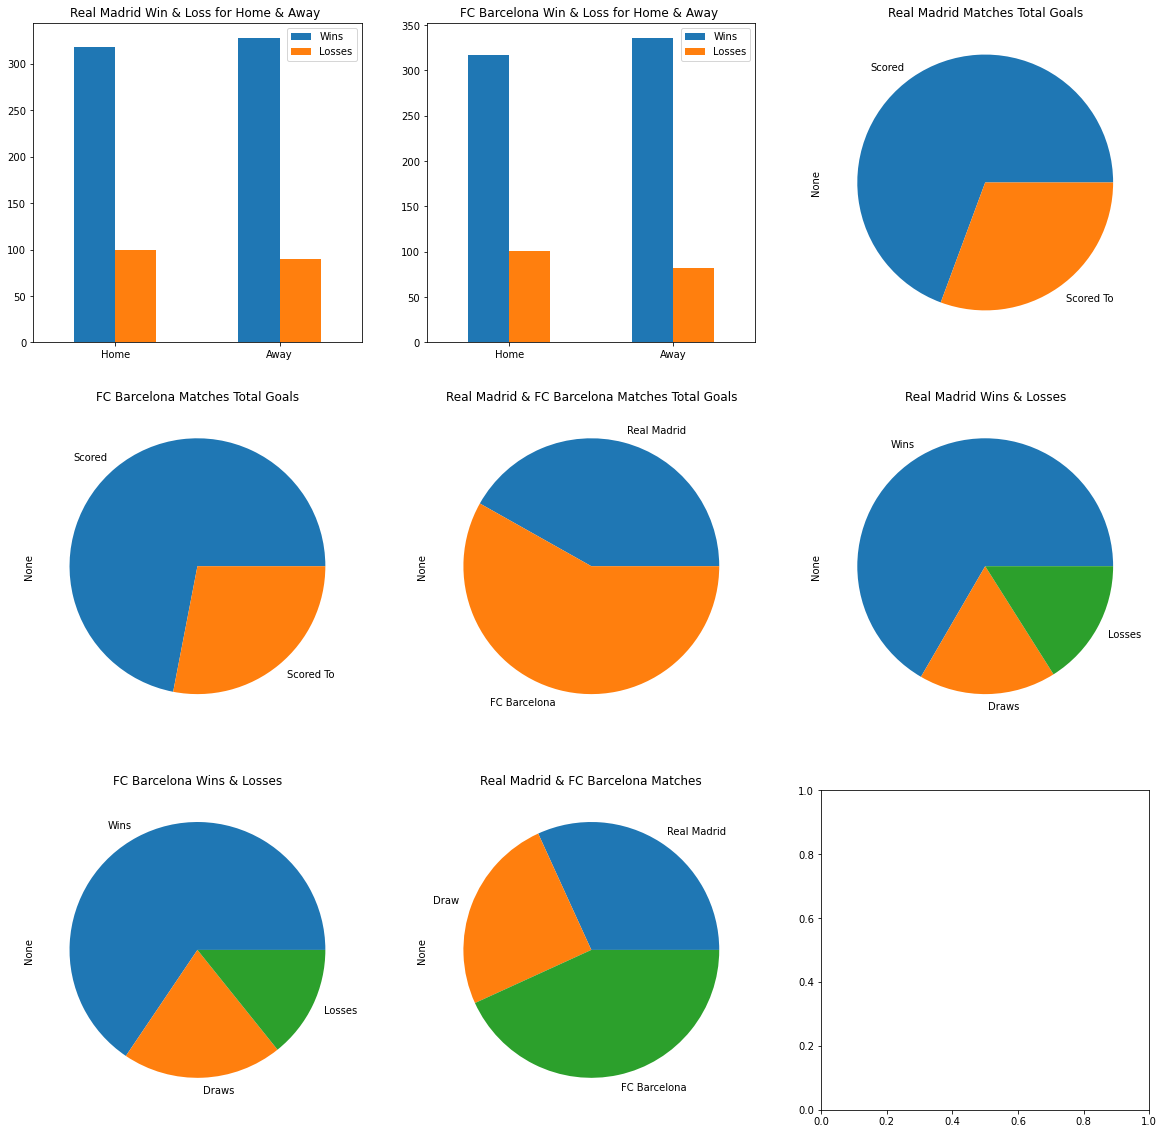

In [43]:
df = df1.copy()
#clean data and make EDA
df = cleanDataAndMakeEda(df,'Real Madrid','FC Barcelona')
#use machine learning on that dataframe
y_pred,resDF,evelList = logisticRegerssion(df)
#print list of evaluate value
print(evelList)
#print DF of predict and actual
resDF

[0.6, 0.8000000000000002, 1.0, 0.8000000000000002, 1.0, 1.0]


,Actual,Predicted
2089,1,1
3958,1,1
7031,1,1
2609,1,1
7412,1,1


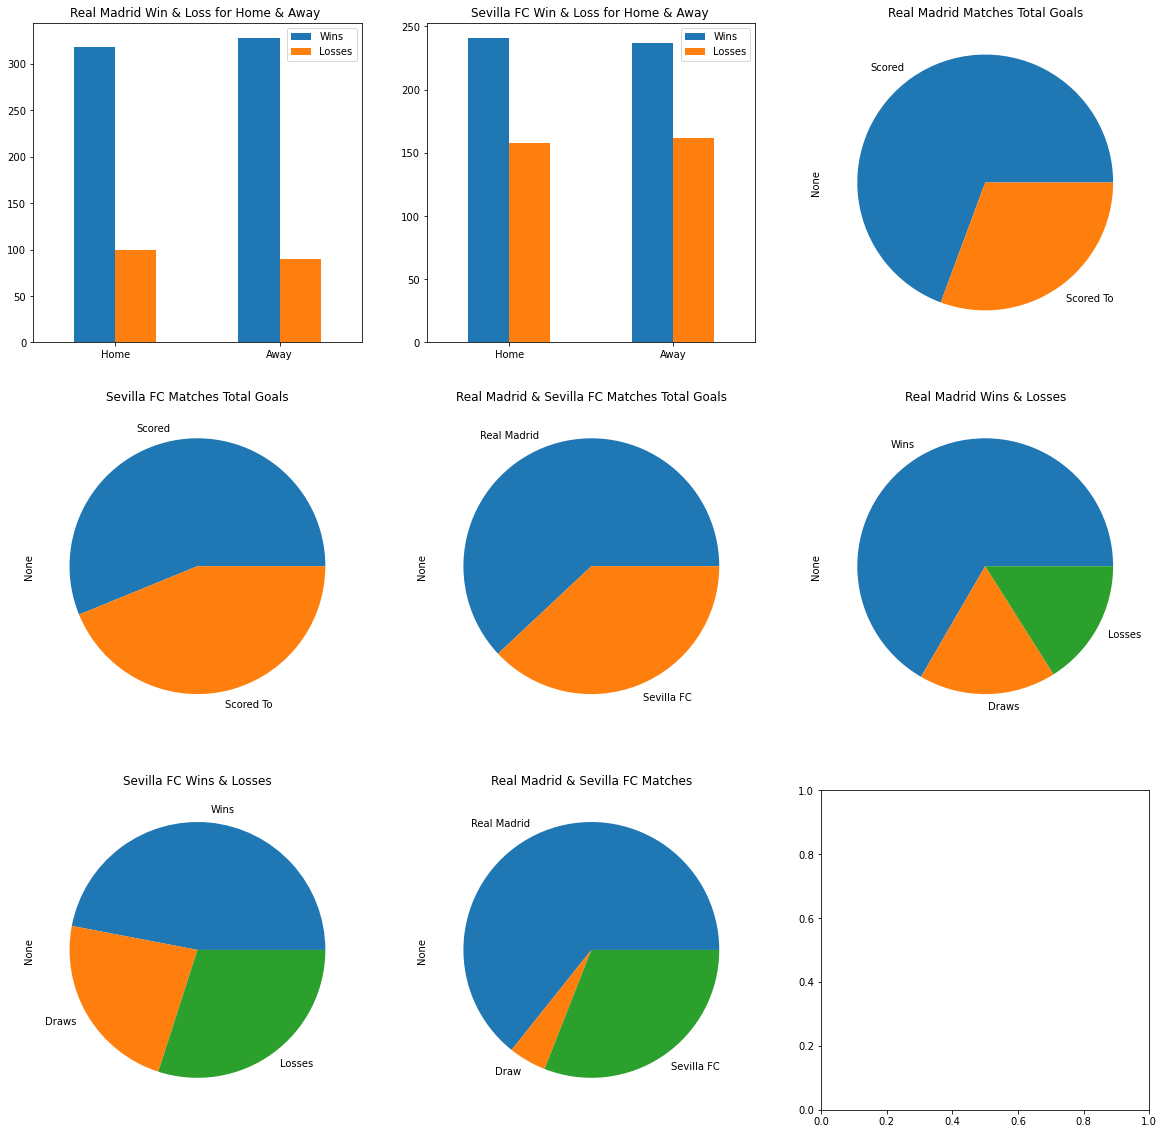

In [47]:
df = df1.copy()
#clean data and make EDA
df = cleanDataAndMakeEda(df,'Real Madrid','Sevilla FC')
#use machine learning on that dataframe
y_pred,resDF,evelList = logisticRegerssion(df)
#print list of evaluate value
print(evelList)
#print DF of predict and actual
resDF

[0.6, 0.8000000000000002, 1.0, 0.8000000000000002, 1.0, 1.0, 0.8000000000000002]


,Actual,Predicted
6373,1,1
1153,0,0
899,2,0
5433,1,1
7299,1,1


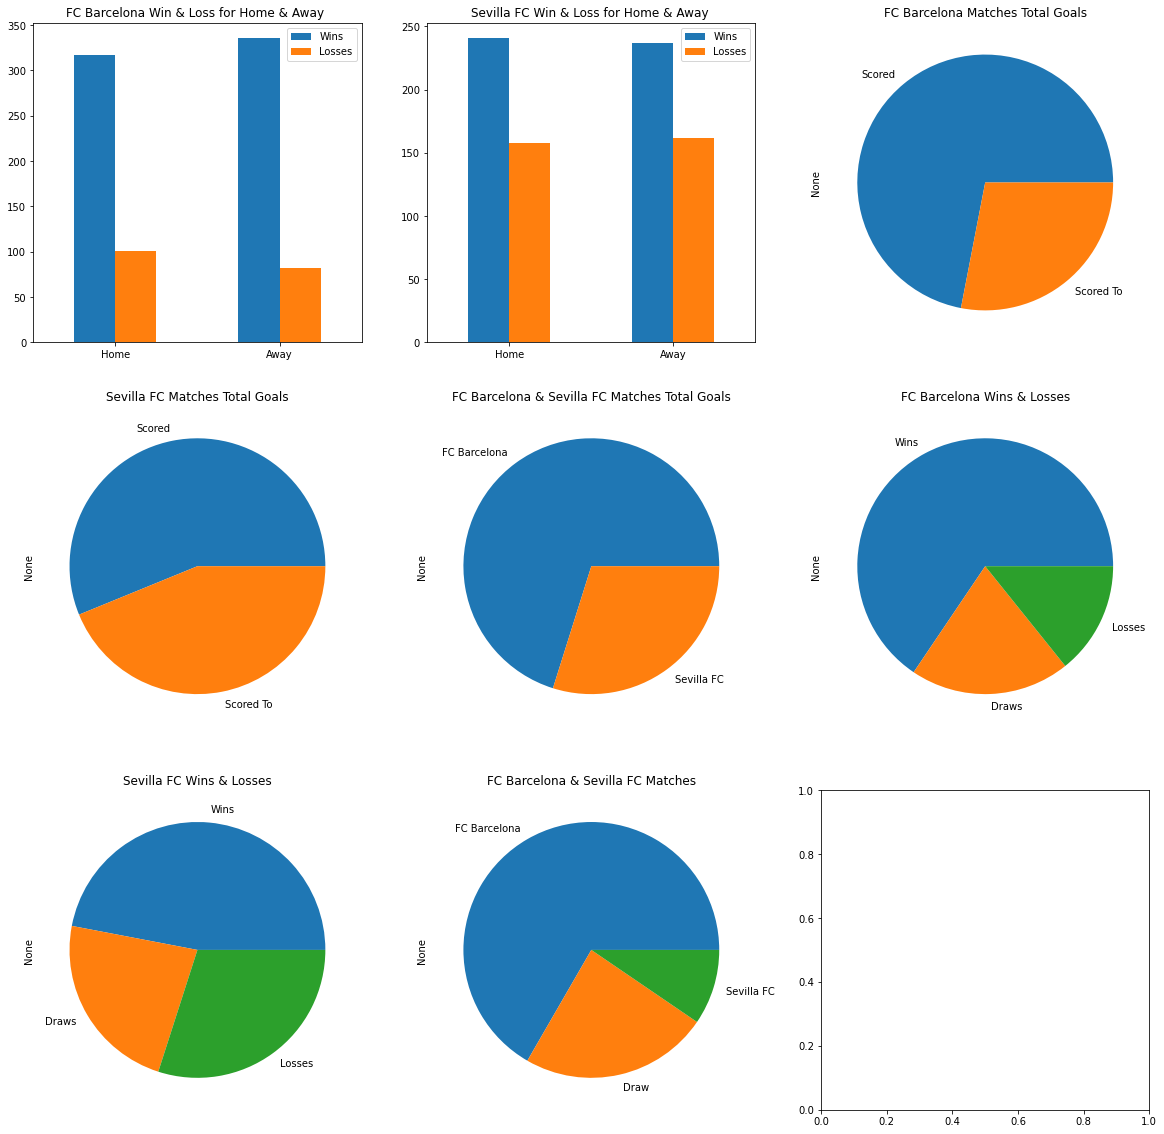

In [48]:
df = df1.copy()
#clean data and make EDA
df = cleanDataAndMakeEda(df,'FC Barcelona','Sevilla FC')
#use machine learning on that dataframe
y_pred,resDF,evelList = logisticRegerssion(df)
#print list of evaluate value
print(evelList)
#print DF of predict and actual
resDF